In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import json
import mysql.connector
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#import sqlalchemy
import warnings
warnings.filterwarnings('ignore')

with open("/Users/sienlong/Dropbox/2. Learning for Life/DigiPen/CET1031 Databases and Data Modelling/secrets.json") as f:
           data = json.load(f)
           config = data['mysql_connector']
           
ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'white',
    'grid.linewidth': '1.2',
    'xtick.color': '555555',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': '555555',
    'ytick.major.left': True,
    'ytick.minor.left': False,
}

plt.rcParams.update(ggplot_styles)

## Loans - Timeseries

In [4]:
try:
    cnx = mysql.connector.connect(**config)
    loans_timeseries = pd.read_sql_query(
        '''
        WITH rolling_avg_table AS 
        (SELECT 
            `year_month`,
            AVG(COUNT(loan_id)) OVER(ORDER BY `year_month` ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS 'moving_avg'
        FROM loan
        GROUP BY `year_month`
        )

        SELECT 
            l.year_month AS year,
            l.loan_type,
            COUNT(l.loan_id) AS "loans issued",
            moving_avg
        FROM loan l
        INNER JOIN rolling_avg_table r ON (l.year_month = r.year_month)
        GROUP BY l.year_month, l.loan_type
        ORDER BY year;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()

# Preparing data for plotting
loans_timeseries['year'] = pd.to_datetime(loans_timeseries['year'], format='%Y-%m-%d')
loans_timeseries

,year,loan_type,loans issued,moving_avg
0,1993-07-01,bad,1,3.0000
1,1993-07-01,good,2,3.0000
2,1993-08-01,good,1,2.0000
3,1993-09-01,bad,1,2.6667
4,1993-09-01,good,3,2.6667
...,...,...,...,...
100,1998-09-01,good,14,15.2500
101,1998-10-01,bad,1,14.8333
102,1998-10-01,good,9,14.8333
103,1998-11-01,good,8,14.4167


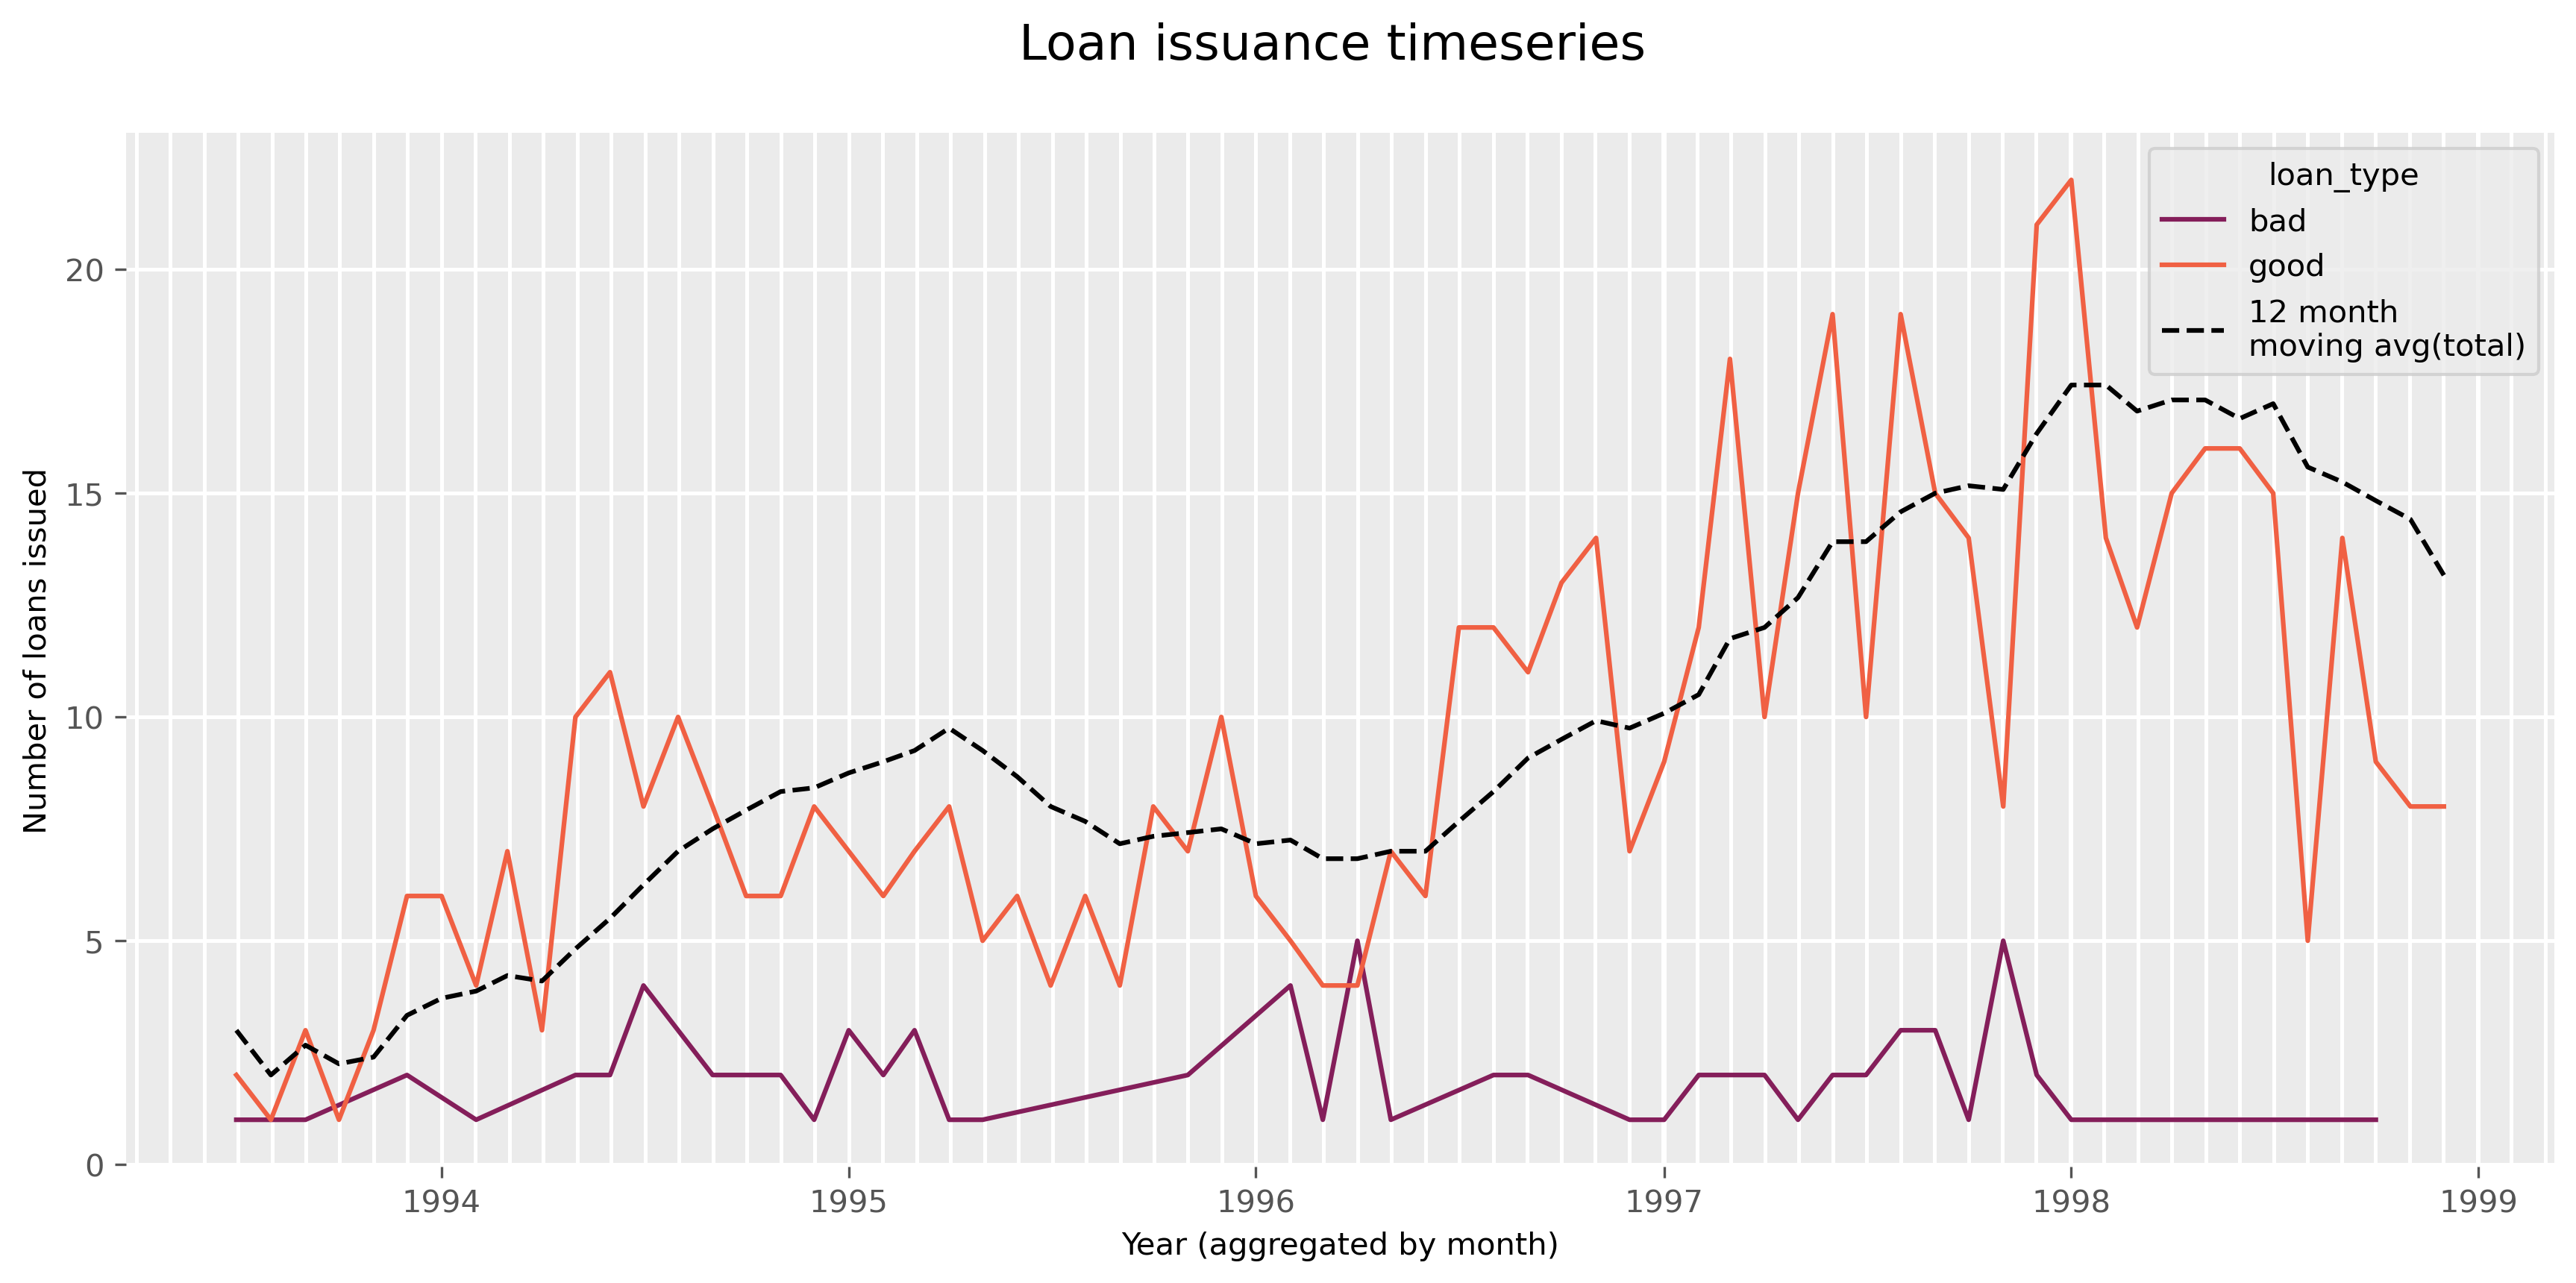

In [5]:
# For drawing a line on year
'''
date_str = '1995-01-01'  # format: YYYY-MM-DD
date_format = '%Y-%m-%d'
date_1995 = pd.to_datetime(date_str, format=date_format)
ax1.axvline(x=date_1995, ymin=0, ymax=1, c="black", linewidth=1, linestyle='--')
'''

fig, ax1 = plt.subplots(1,1, figsize = (14,6), dpi=300)
sns.lineplot(data = loans_timeseries, x='year', y='loans issued', hue='loan_type', ax=ax1, palette='rocket')
ax1.set_title('Loan issuance timeseries \n', fontdict={'size':16})
ax1.set_xlabel("Year (aggregated by month)")
ax1.set_ylabel("Number of loans issued")
ax1.xaxis.set_minor_locator(AutoMinorLocator(12))
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.plot(loans_timeseries['year'], loans_timeseries['moving_avg'], color='black', linestyle='dashed', label='12 month\nmoving avg(total)')
ax1.legend(title='loan_type')
plt.show()


In [40]:
try:
    cnx = mysql.connector.connect(**config)
    unemployment = pd.read_sql_query(
        '''
        WITH y1995 AS (
            SELECT region, COUNT(loan_id) as loans_1995
            FROM district d, account a, loan l
            WHERE (d.district_id = a.district_id)
            AND (a.account_id = l.account_id)
            AND (loan_id IS NOT NULL)
            AND YEAR(date) = 1995 AND MONTH(date) in (4,5,6,7,8,9,10,11,12)
            GROUP BY region
        ),

        y1996 AS (
            SELECT region, COUNT(loan_id) as loans_1996
            FROM district d, account a, loan l
            WHERE (d.district_id = a.district_id)
            AND (a.account_id = l.account_id)
            AND (loan_id IS NOT NULL)
            AND YEAR(date) = 1996 AND MONTH(date) in (1,2,3,4)
            GROUP BY region
        ),

        country AS (
            SELECT 
            ROUND(AVG(unemployment_1995),2) AS "average_unemployment_95",
            ROUND(AVG(unemployment_1996),2) AS "average_unemployment_96",
            ROUND(AVG(unemployment_1996) - AVG(unemployment_1995),2) AS "country_average_change_in_unemployment"
            FROM district)

        SELECT 
            d.region,
            loans_1996 - loans_1995 AS "change_in_loans",
            ROUND(AVG(unemployment_1996) - AVG(unemployment_1995),2) AS "change_in_unemployment",
            country_average_change_in_unemployment
        FROM district d
        LEFT JOIN y1995 ON (y1995.region = d.region)
        LEFT JOIN y1996 ON (y1996.region = d.region)
        CROSS JOIN country c
        GROUP BY region
        ORDER BY change_in_unemployment DESC;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
unemployment['display'] = unemployment['change_in_loans'].astype("str") + '\n' + unemployment['region']
unemployment

,region,change_in_loans,change_in_unemployment,country_average_change_in_unemployment,display
0,north Moravia,-3,1.30,0.71,-3\nnorth Moravia
1,north Bohemia,-4,1.05,0.71,-4\nnorth Bohemia
2,east Bohemia,-1,0.62,0.71,-1\neast Bohemia
3,south Moravia,-7,0.60,0.71,-7\nsouth Moravia
4,south Bohemia,-3,0.54,0.71,-3\nsouth Bohemia
5,west Bohemia,-3,0.51,0.71,-3\nwest Bohemia
6,central Bohemia,-7,0.41,0.71,-7\ncentral Bohemia
7,Prague,-5,0.14,0.71,-5\nPrague


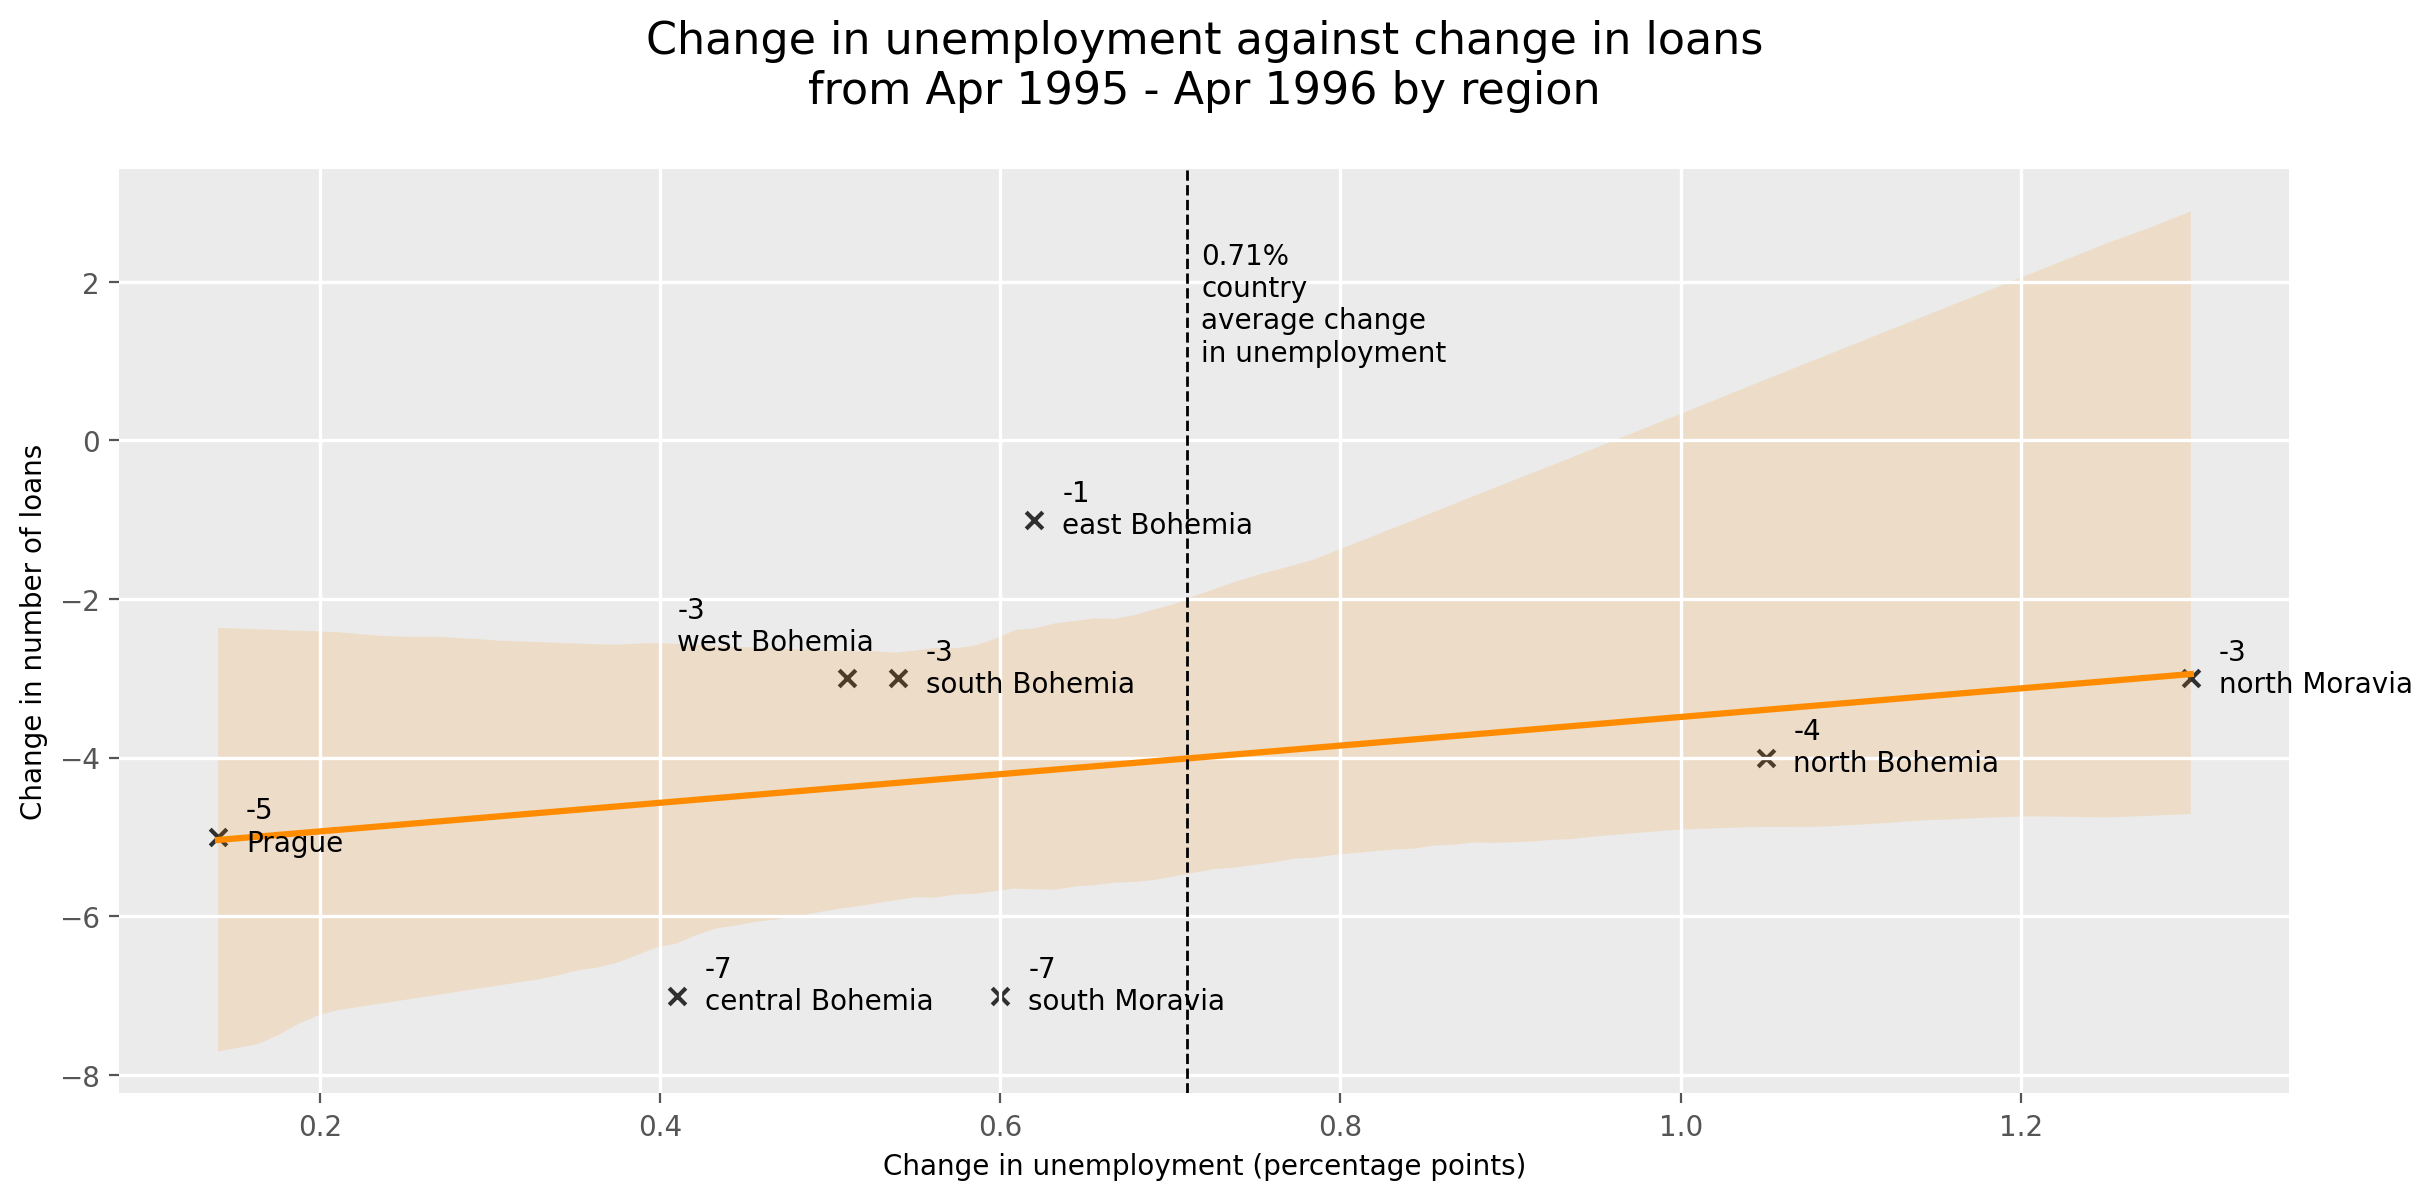

In [8]:
fig, ax1 = plt.subplots(1,1, figsize=(14,6), dpi=200)

# Good Loans correlation
sns.regplot(data=unemployment, x='change_in_unemployment', y="change_in_loans", ax=ax1, marker='x',
            robust=False, n_boot=1000, scatter_kws={"color": "black",}, line_kws={"color": "darkorange"})
ax1.set_title("Change in unemployment against change in loans\nfrom Apr 1995 - Apr 1996 by region\n", fontdict={'size':16})
ax1.set_xlabel("Change in unemployment (percentage points)")
ax1.set_ylabel("Change in number of loans")
ax1.axvline(x=0.71, ymin=0, ymax=1, c="black", linewidth=1, linestyle='--')
ax1.annotate('0.71%\ncountry\naverage change\nin unemployment', (0.71,1), 
                xytext=(5,0), textcoords='offset points')

for i, txt in enumerate(unemployment['display']):
    if i==5:
        ax1.annotate(txt, (unemployment['change_in_unemployment'][i]-0.1, unemployment['change_in_loans'][i]), 
                xytext=(0,10), textcoords='offset points')
    else:
        ax1.annotate(txt, (unemployment['change_in_unemployment'][i], unemployment['change_in_loans'][i]), 
                    xytext=(10,-5), textcoords='offset points')

In [11]:
try:
    cnx = mysql.connector.connect(**config)
    top_10_loans = pd.read_sql_query(
        '''
        WITH population AS(
            SELECT 
                district_id, 
                DENSE_RANK() OVER(ORDER BY inhabitants DESC) population_rank
            FROM district
        )

        SELECT 
            d.district_name, 
            COUNT(loan_id) AS 'loans_per_district',
            population_rank
        FROM district d, account a, loan l, population p
        WHERE (d.district_id = a.district_id)
        AND (l.account_id = a.account_id)
        AND (p.district_id = d.district_id)
        AND (loan_id IS NOT NULL)
        GROUP BY d.district_id
        ORDER BY loans_per_district DESC
        LIMIT 10;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
top_10_loans['legend'] = top_10_loans['population_rank'].astype('str') + ' - ' + top_10_loans['district_name']
top_10_loans

,district_name,loans_per_district,population_rank,legend
0,Hl.m. Praha,84,1,1 - Hl.m. Praha
1,Karvina,24,4,4 - Karvina
2,Brno - mesto,24,2,2 - Brno - mesto
3,Ostrava - mesto,20,3,3 - Ostrava - mesto
4,Zlin,17,7,7 - Zlin
5,Frydek - Mistek,16,5,5 - Frydek - Mistek
6,Prachatice,14,74,74 - Prachatice
7,Olomouc,14,6,6 - Olomouc
8,Usti nad Orlici,14,20,20 - Usti nad Orlici
9,Louny,13,58,58 - Louny


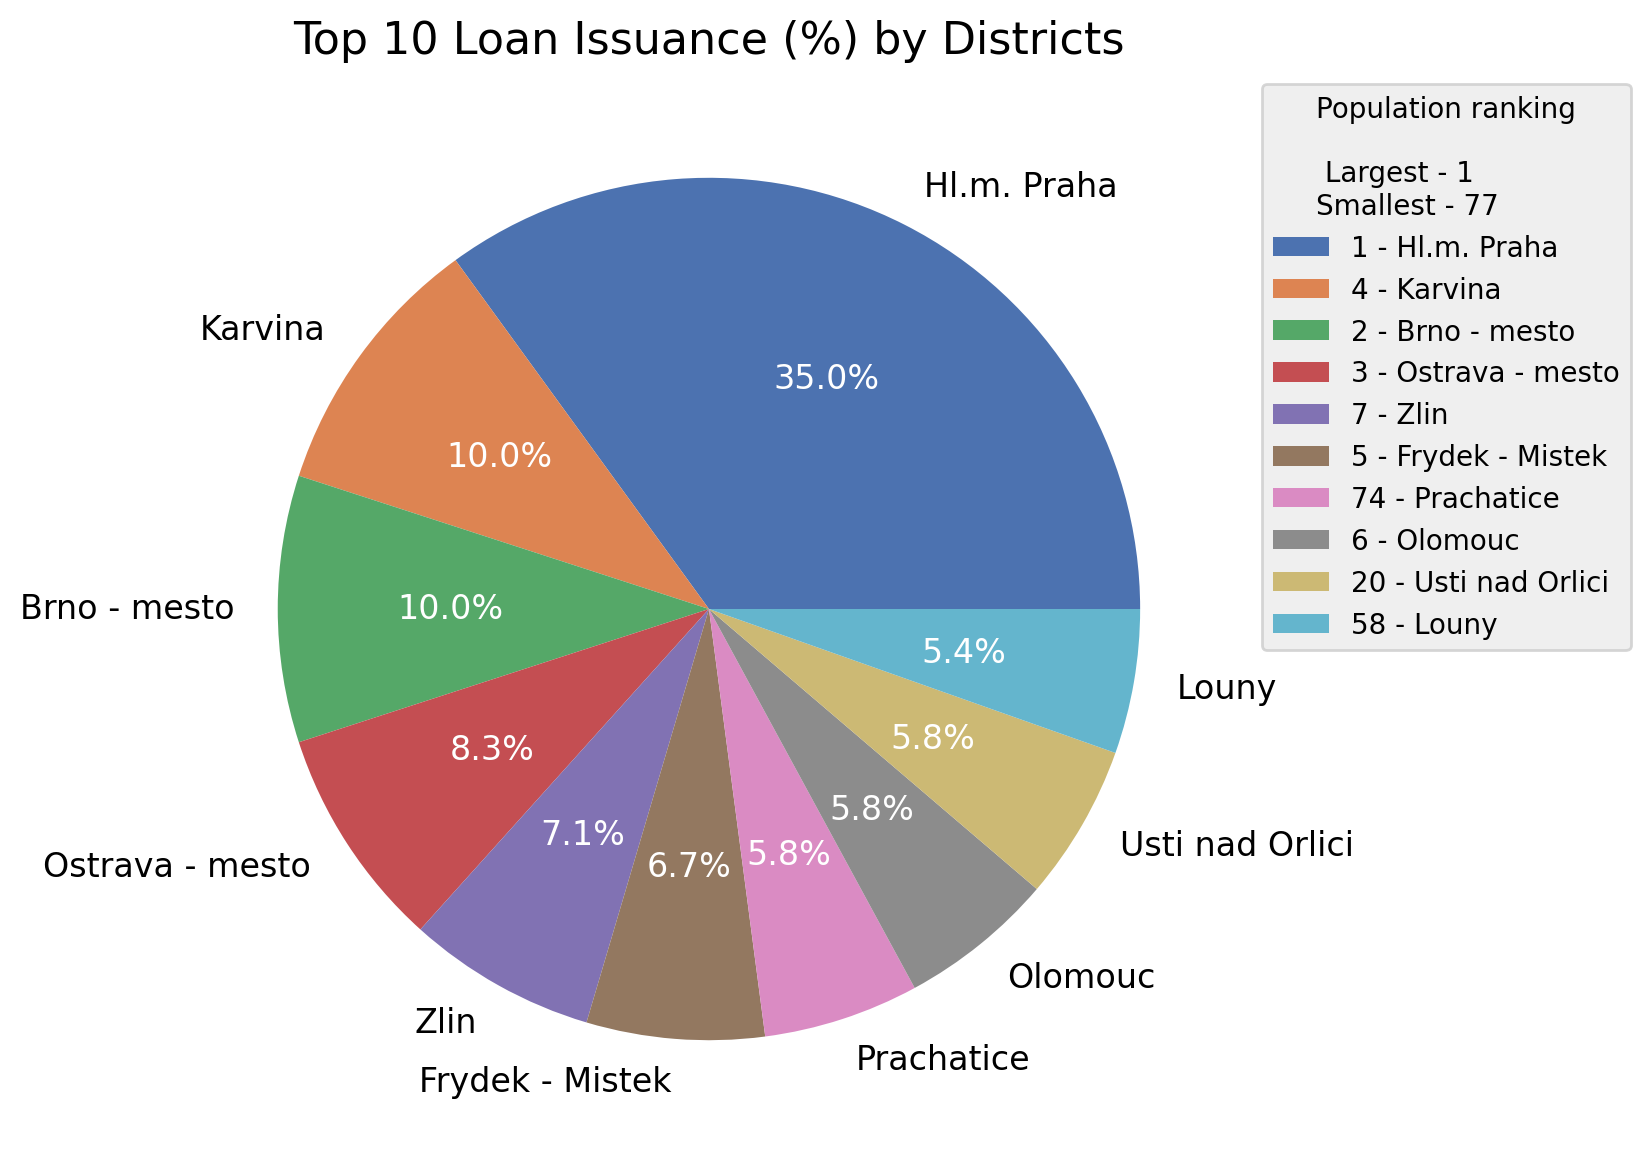

In [12]:
fig, ax = plt.subplots(figsize=(7,7), dpi=200, subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%" #\n({absolute:d})"

wedges, texts, autotexts = ax.pie(top_10_loans['loans_per_district'], 
                                  autopct=lambda pct: func(pct, top_10_loans['loans_per_district']),
                                  labels=top_10_loans['district_name'], colors=sns.color_palette('deep'))
                                  #textprops=dict(color="w"))

ax.legend(wedges, top_10_loans['legend'],
          title="Population ranking\n\n Largest - 1\nSmallest - 77",
          loc="upper left",
          prop={'size': 10},
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, color='w')
plt.setp(texts, size=12)
ax.set_title('Top 10 Loan Issuance (%) by Districts', fontdict={'size':16})

plt.show()

## Data on top population and urban ratio

In [76]:
try:
    cnx = mysql.connector.connect(**config)
    top_10_population = pd.read_sql_query(
        '''
        WITH total_table AS(
                SELECT SUM(inhabitants) as total
                FROM district
        )

        SELECT 
        district_name, 
        region,
        inhabitants/t.total*100 AS 'percent of total population'
        FROM district d
        CROSS JOIN total_table t
        ORDER BY inhabitants/t.total*100 DESC
        LIMIT 10;
        ''', con = cnx
    )
except Exception as e:
    print(f"Error connecting to MariaDB Platform: {e}")
finally:
    cnx.close()
top_10_population

,district_name,region,urban_inhabitant_ratio,percent of total population
0,Hl.m. Praha,Prague,100.0,11.6882
1,Brno - mesto,south Moravia,100.0,3.7595
2,Ostrava - mesto,north Moravia,100.0,3.1416
3,Karvina,north Moravia,89.9,2.7683
4,Frydek - Mistek,north Moravia,57.2,2.2199
5,Olomouc,north Moravia,62.6,2.1934
6,Zlin,south Moravia,74.7,1.9119
7,Opava,north Moravia,56.4,1.7657
8,Ceske Budejovice,south Bohemia,74.8,1.7236
9,Plzen - mesto,west Bohemia,100.0,1.6534


In [13]:
try:
    cnx = mysql.connector.connect(**config)
    top_10_loans_region = pd.read_sql_query(
        '''
        WITH population AS(
            SELECT 
                region, 
                DENSE_RANK() OVER(ORDER BY SUM(inhabitants) DESC) population_rank
            FROM district
            GROUP BY region
        )

        SELECT 
            d.region,
            COUNT(loan_id) AS 'loans_per_region',
            population_rank
        FROM district d, account a, loan l, population p
        WHERE (d.district_id = a.district_id)
        AND (l.account_id = a.account_id)
        AND (p.region = d.region)
        AND (loan_id IS NOT NULL)
        GROUP BY d.region
        ORDER BY loans_per_region DESC
        ''', con = cnx
    )
except Exception as e:
    print(f"Error connecting to MariaDB Platform: {e}")
finally:
    cnx.close()
top_10_loans_region['legend'] = top_10_loans_region['population_rank'].astype('str') + ' - ' + top_10_loans_region['region']
top_10_loans_region

,region,loans_per_region,population_rank,legend
0,south Moravia,129,1,1 - south Moravia
1,north Moravia,117,2,2 - north Moravia
2,central Bohemia,90,6,6 - central Bohemia
3,Prague,84,4,4 - Prague
4,east Bohemia,84,3,3 - east Bohemia
5,north Bohemia,61,5,5 - north Bohemia
6,south Bohemia,60,8,8 - south Bohemia
7,west Bohemia,57,7,7 - west Bohemia


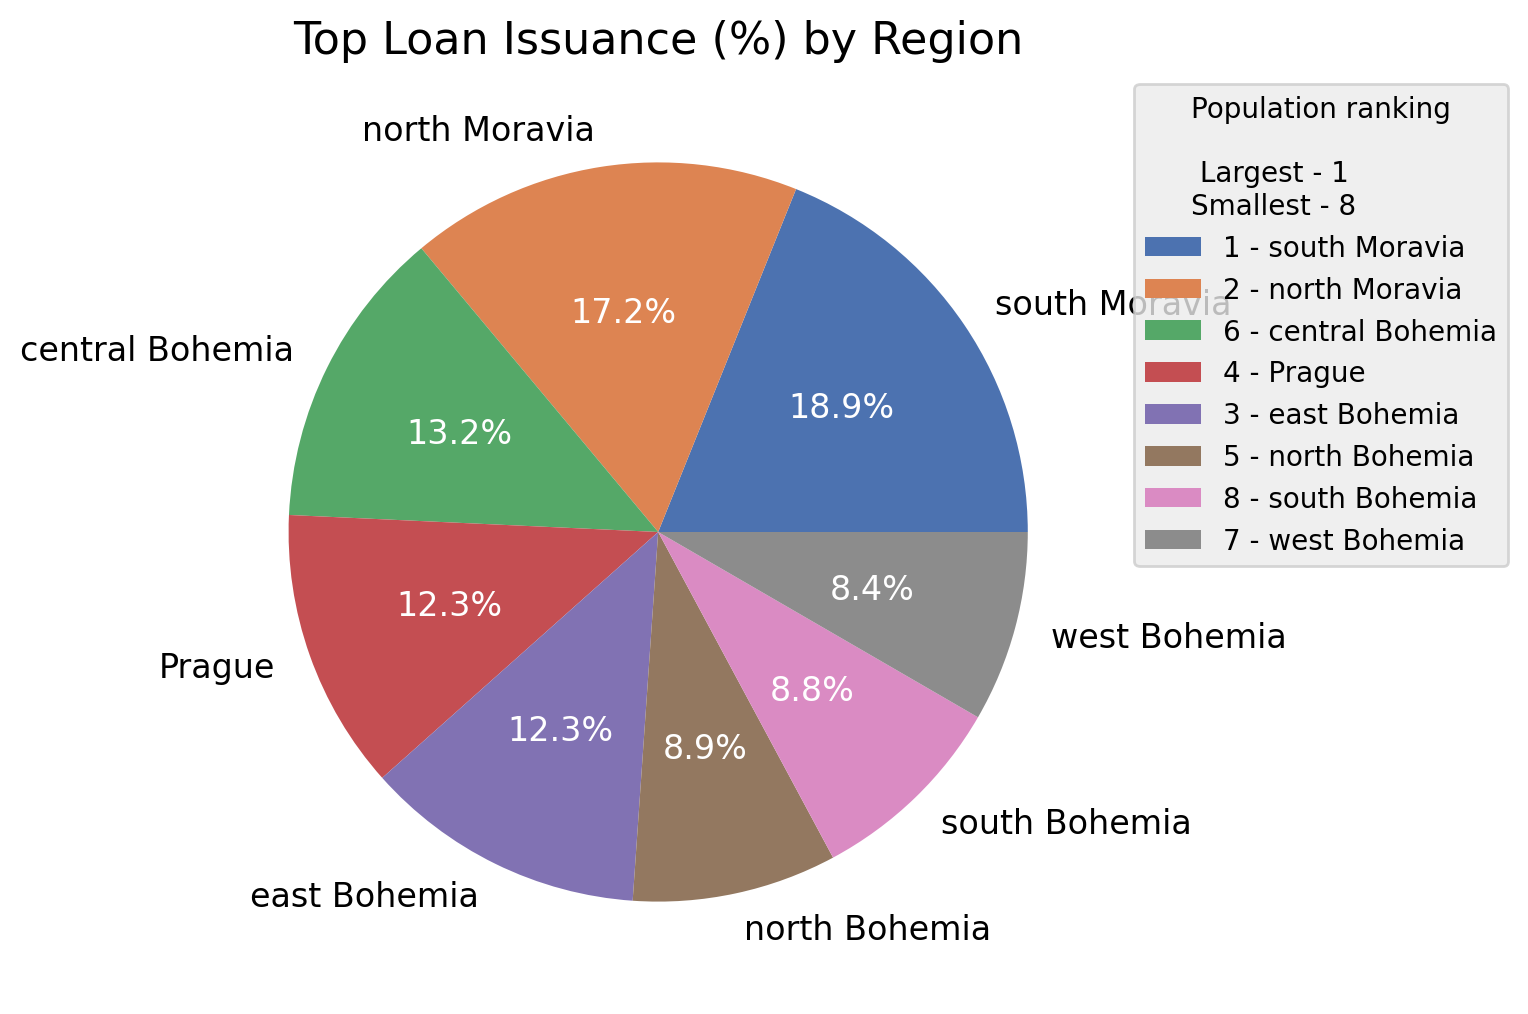

In [14]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200, subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%" #\n({absolute:d})"

wedges, texts, autotexts = ax.pie(top_10_loans_region['loans_per_region'], 
                                  autopct=lambda pct: func(pct, top_10_loans_region['loans_per_region']),
                                  labels=top_10_loans_region['region'], colors=sns.color_palette('deep'))
                                  #textprops=dict(color="w"))

ax.legend(wedges, top_10_loans_region['legend'],
          title="Population ranking\n\n Largest - 1\nSmallest - 8",
          loc="upper left",
          prop={'size': 10},
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, color='w')
plt.setp(texts, size=12)
ax.set_title('Top Loan Issuance (%) by Region', fontdict={'size':16})

plt.show()

In [10]:
try:
    cnx = mysql.connector.connect(**config)
    region_loans = pd.read_sql_query(
        '''
        WITH bad_loans_table AS(
            SELECT 
                region,
                COUNT(loan_id) AS 'bad_loans'
            FROM district d, account a, loan l
            WHERE (d.district_id = a.district_id)
            AND (l.account_id = a.account_id)
            AND (loan_id IS NOT NULL)
            AND (loan_type = "bad")
            GROUP BY region
        ),
        good_loans_table AS(
            SELECT 
                region,
                COUNT(loan_id) AS 'good_loans'
            FROM district d, account a, loan l
            WHERE (d.district_id = a.district_id)
            AND (l.account_id = a.account_id)
            AND (loan_id IS NOT NULL)
            AND (loan_type = "good")
            GROUP BY region
        )

        SELECT 
            d.region,
            ROUND(SUM(inhabitants),0) AS population,
            bad_loans,
            good_loans,
            bad_loans+good_loans AS "total",
            good_loans/(bad_loans+good_loans)*100 AS "% good loans",
            bad_loans/(bad_loans+good_loans)*100 AS "% bad loans"
        FROM district d
        LEFT JOIN bad_loans_table bl ON (d.region = bl.region)
        LEFT JOIN good_loans_table gl ON (d.region = gl.region)
        GROUP BY region
        ORDER BY population DESC;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
region_loans

,region,population,bad_loans,good_loans,total,% good loans,% bad loans
0,south Moravia,2054989.0,13,116,129,89.9225,10.0775
1,north Moravia,1970302.0,18,99,117,84.6154,15.3846
2,east Bohemia,1234781.0,9,75,84,89.2857,10.7143
3,Prague,1204953.0,7,77,84,91.6667,8.3333
4,north Bohemia,1178977.0,1,60,61,98.3607,1.6393
5,central Bohemia,1105234.0,10,80,90,88.8889,11.1111
6,west Bohemia,859306.0,9,48,57,84.2105,15.7895
7,south Bohemia,700595.0,9,51,60,85.0000,15.0000


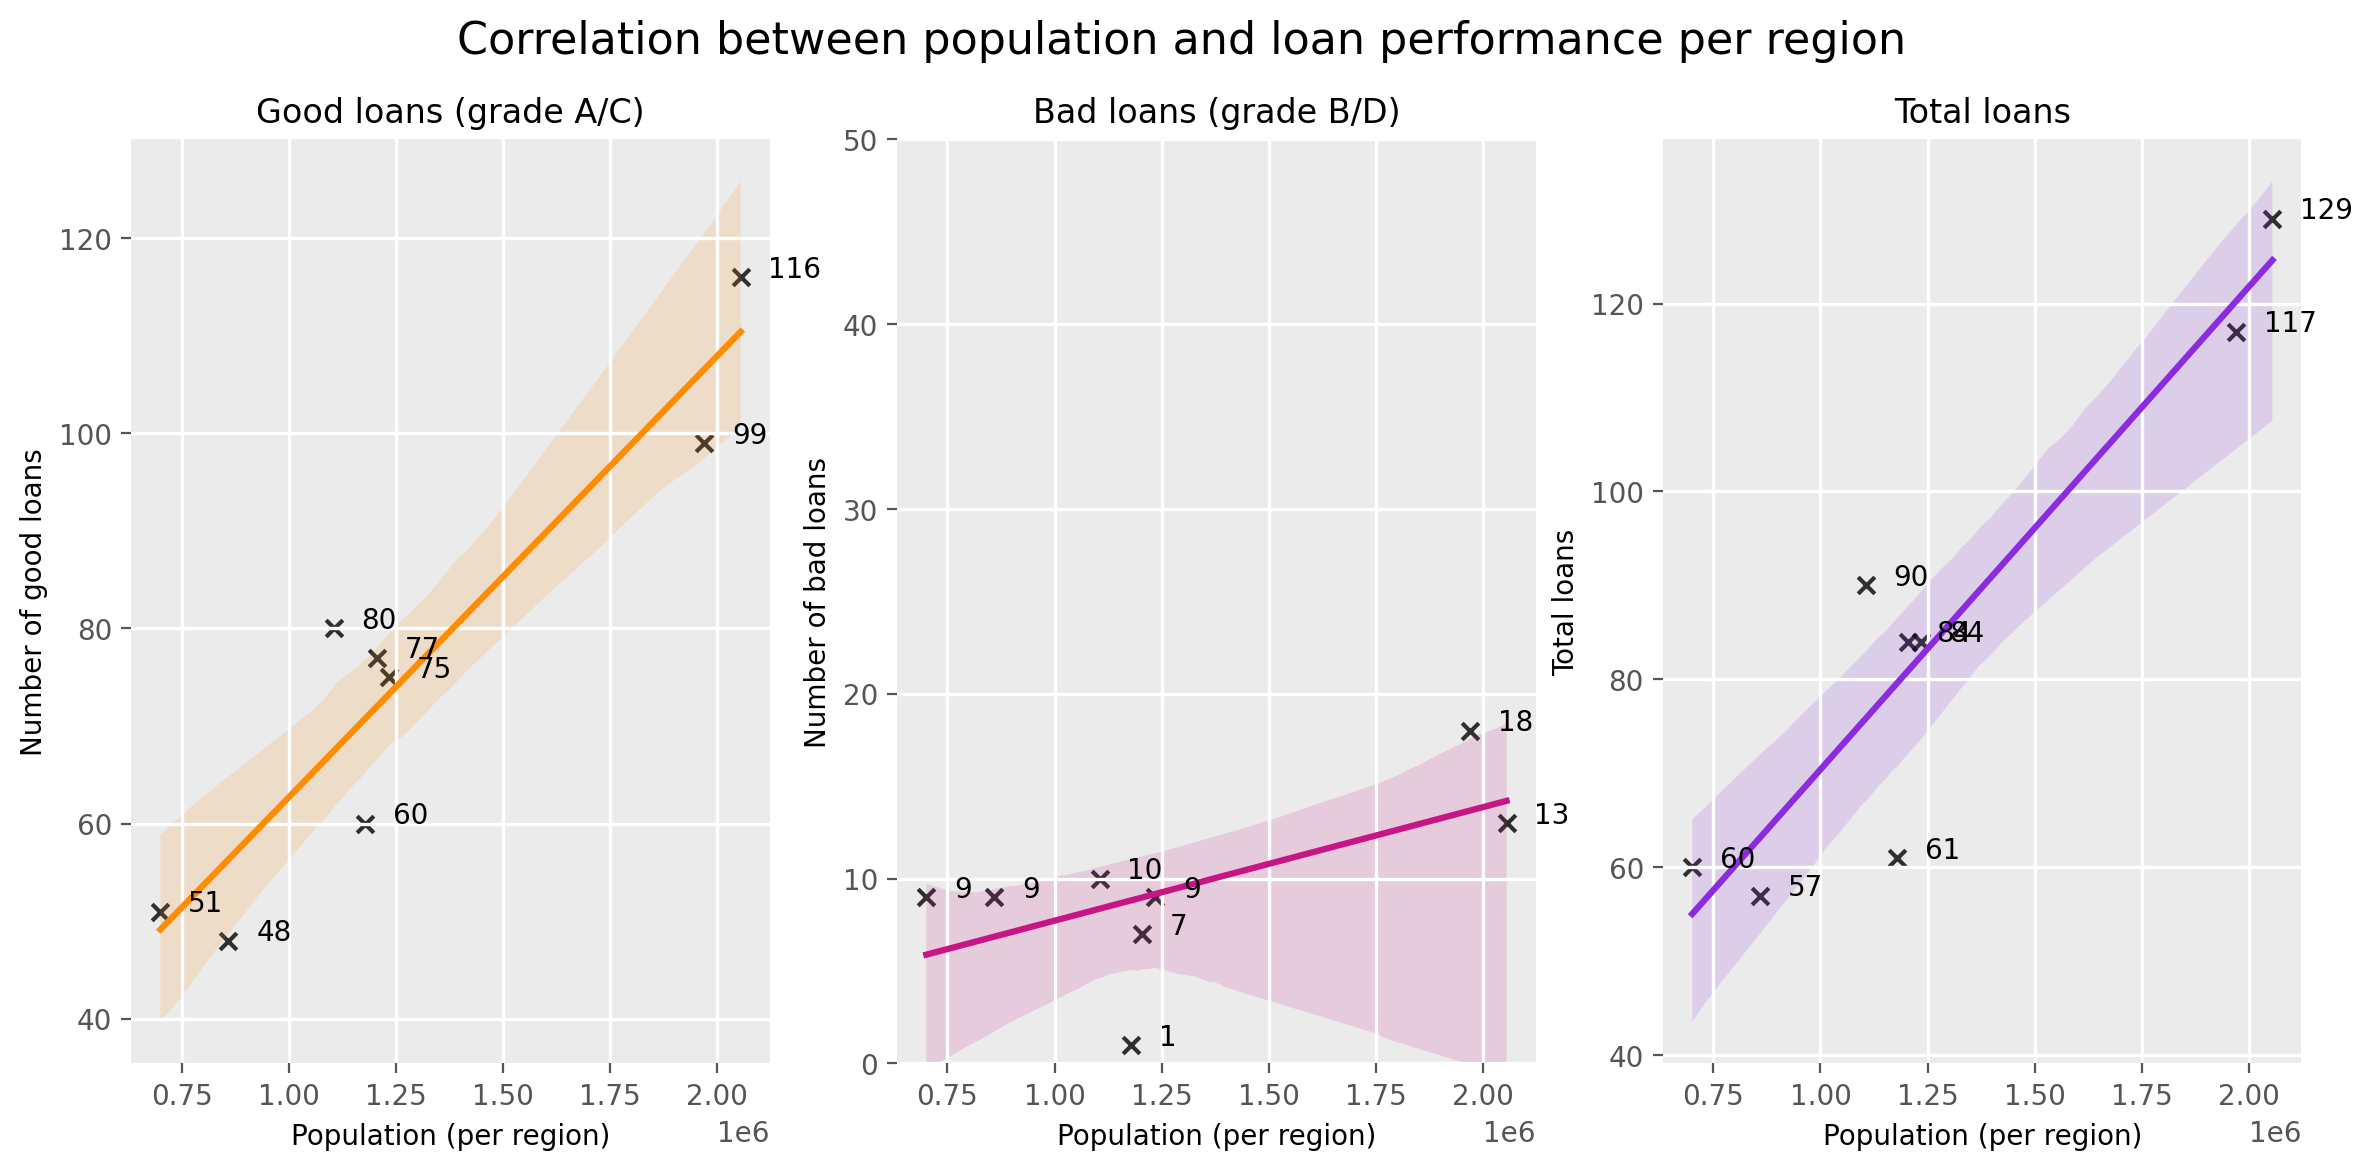

In [66]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,6), dpi=200)
plt.suptitle('Correlation between population and loan performance per region', fontsize=16)

# Good Loans correlation
sns.regplot(data=region_loans, x='population', y="good_loans", ax=ax1, marker='x',
            robust=False, n_boot=1000, scatter_kws={"color": "black",}, line_kws={"color": "darkorange"})
ax1.set_title("Good loans (grade A/C)")
ax1.set_xlabel("Population (per region)")
ax1.set_ylabel("Number of good loans")

for i, txt in enumerate(region_loans['good_loans']):
    ax1.annotate(txt, (region_loans['population'][i], region_loans['good_loans'][i]), 
                 xytext=(10,0), textcoords='offset points')

# Bad Loans correlation
sns.regplot(data=region_loans, x='population', y="bad_loans", ax=ax2, marker='x',
            robust=False, n_boot=1000, scatter_kws={"color": "black",}, line_kws={"color": "mediumvioletred"})
ax2.set_title("Bad loans (grade B/D)")
ax2.set_ybound(lower=0, upper=50)
ax2.set_xlabel("Population (per region)")
ax2.set_ylabel("Number of bad loans")

for i, txt in enumerate(region_loans['bad_loans']):
    ax2.annotate(txt, (region_loans['population'][i], region_loans['bad_loans'][i]), 
                 xytext=(10,0), textcoords='offset points')
    
# Good Loans correlation
sns.regplot(data=region_loans, x='population', y="total", ax=ax3, marker='x',
            robust=False, n_boot=1000, scatter_kws={"color": "black",}, line_kws={"color": "blueviolet"})
ax3.set_title('Total loans')
ax3.set_xlabel("Population (per region)")
ax3.set_ylabel("Total loans")

for i, txt in enumerate(region_loans['total']):
    ax3.annotate(txt, (region_loans['population'][i], region_loans['total'][i]), 
                 xytext=(10,0), textcoords='offset points')
plt.show()

In [ ]:
try:
    cnx = mysql.connector.connect(**config)
    transaction = pd.read_sql_query(
        '''
        transaction
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
transaction

In [70]:
try:
    cnx = mysql.connector.connect(**config)
    trans_loan = pd.read_sql_query(
        '''
        WITH credit AS (
                SELECT t.account_id, ROUND(SUM(t.amount),2) AS `total_credit`
                FROM trans t, account a, loan l
                WHERE (t.account_id = a.account_id)
                AND (a.account_id = l.account_id)
                AND (l.loan_id IS NOT NULL)
                AND (t.type = "credit")
                GROUP BY t.account_id
        ),
        
        withdrawal AS (
                SELECT t.account_id, ROUND(SUM(t.amount),2) AS `total_withdrawal`
                FROM trans t, account a, loan l
                WHERE (t.account_id = a.account_id)
                AND (a.account_id = l.account_id)
                AND (l.loan_id IS NOT NULL)
                AND (t.type = "withdrawal")
                GROUP BY t.account_id
        )

        SELECT DISTINCT(t.account_id), c.total_credit, w.total_withdrawal, c.total_credit-w.total_withdrawal AS `total_inflow/outflow`, l.loan_type
        FROM trans t, account a, loan l, credit c, withdrawal w
        WHERE (t.account_id = a.account_id)
        AND (a.account_id = l.account_id)
        AND (l.loan_id IS NOT NULL)
        AND (t.account_id = c.account_id)
        AND (t.account_id = w.account_id)
        ORDER BY l.loan_type DESC;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
badloan = trans_loan['loan_type']=='bad'
goodloan = trans_loan['loan_type']=='good'
trans_loan

       

,account_id,total_credit,total_withdrawal,total_inflow/outflow,loan_type
0,339,784299.2,1078562.2,-294263.0,good
1,1011,571972.3,785920.8,-213948.5,good
2,1698,402431.3,455764.2,-53332.9,good
3,2116,728529.0,664528.0,64001.0,good
4,2496,321691.8,346074.0,-24382.2,good
...,...,...,...,...,...
677,8225,457989.5,402326.8,55662.7,bad
678,10266,1658758.1,1590229.5,68528.6,bad
679,442,343628.3,293118.8,50509.5,bad
680,2176,1526657.0,1556672.5,-30015.5,bad


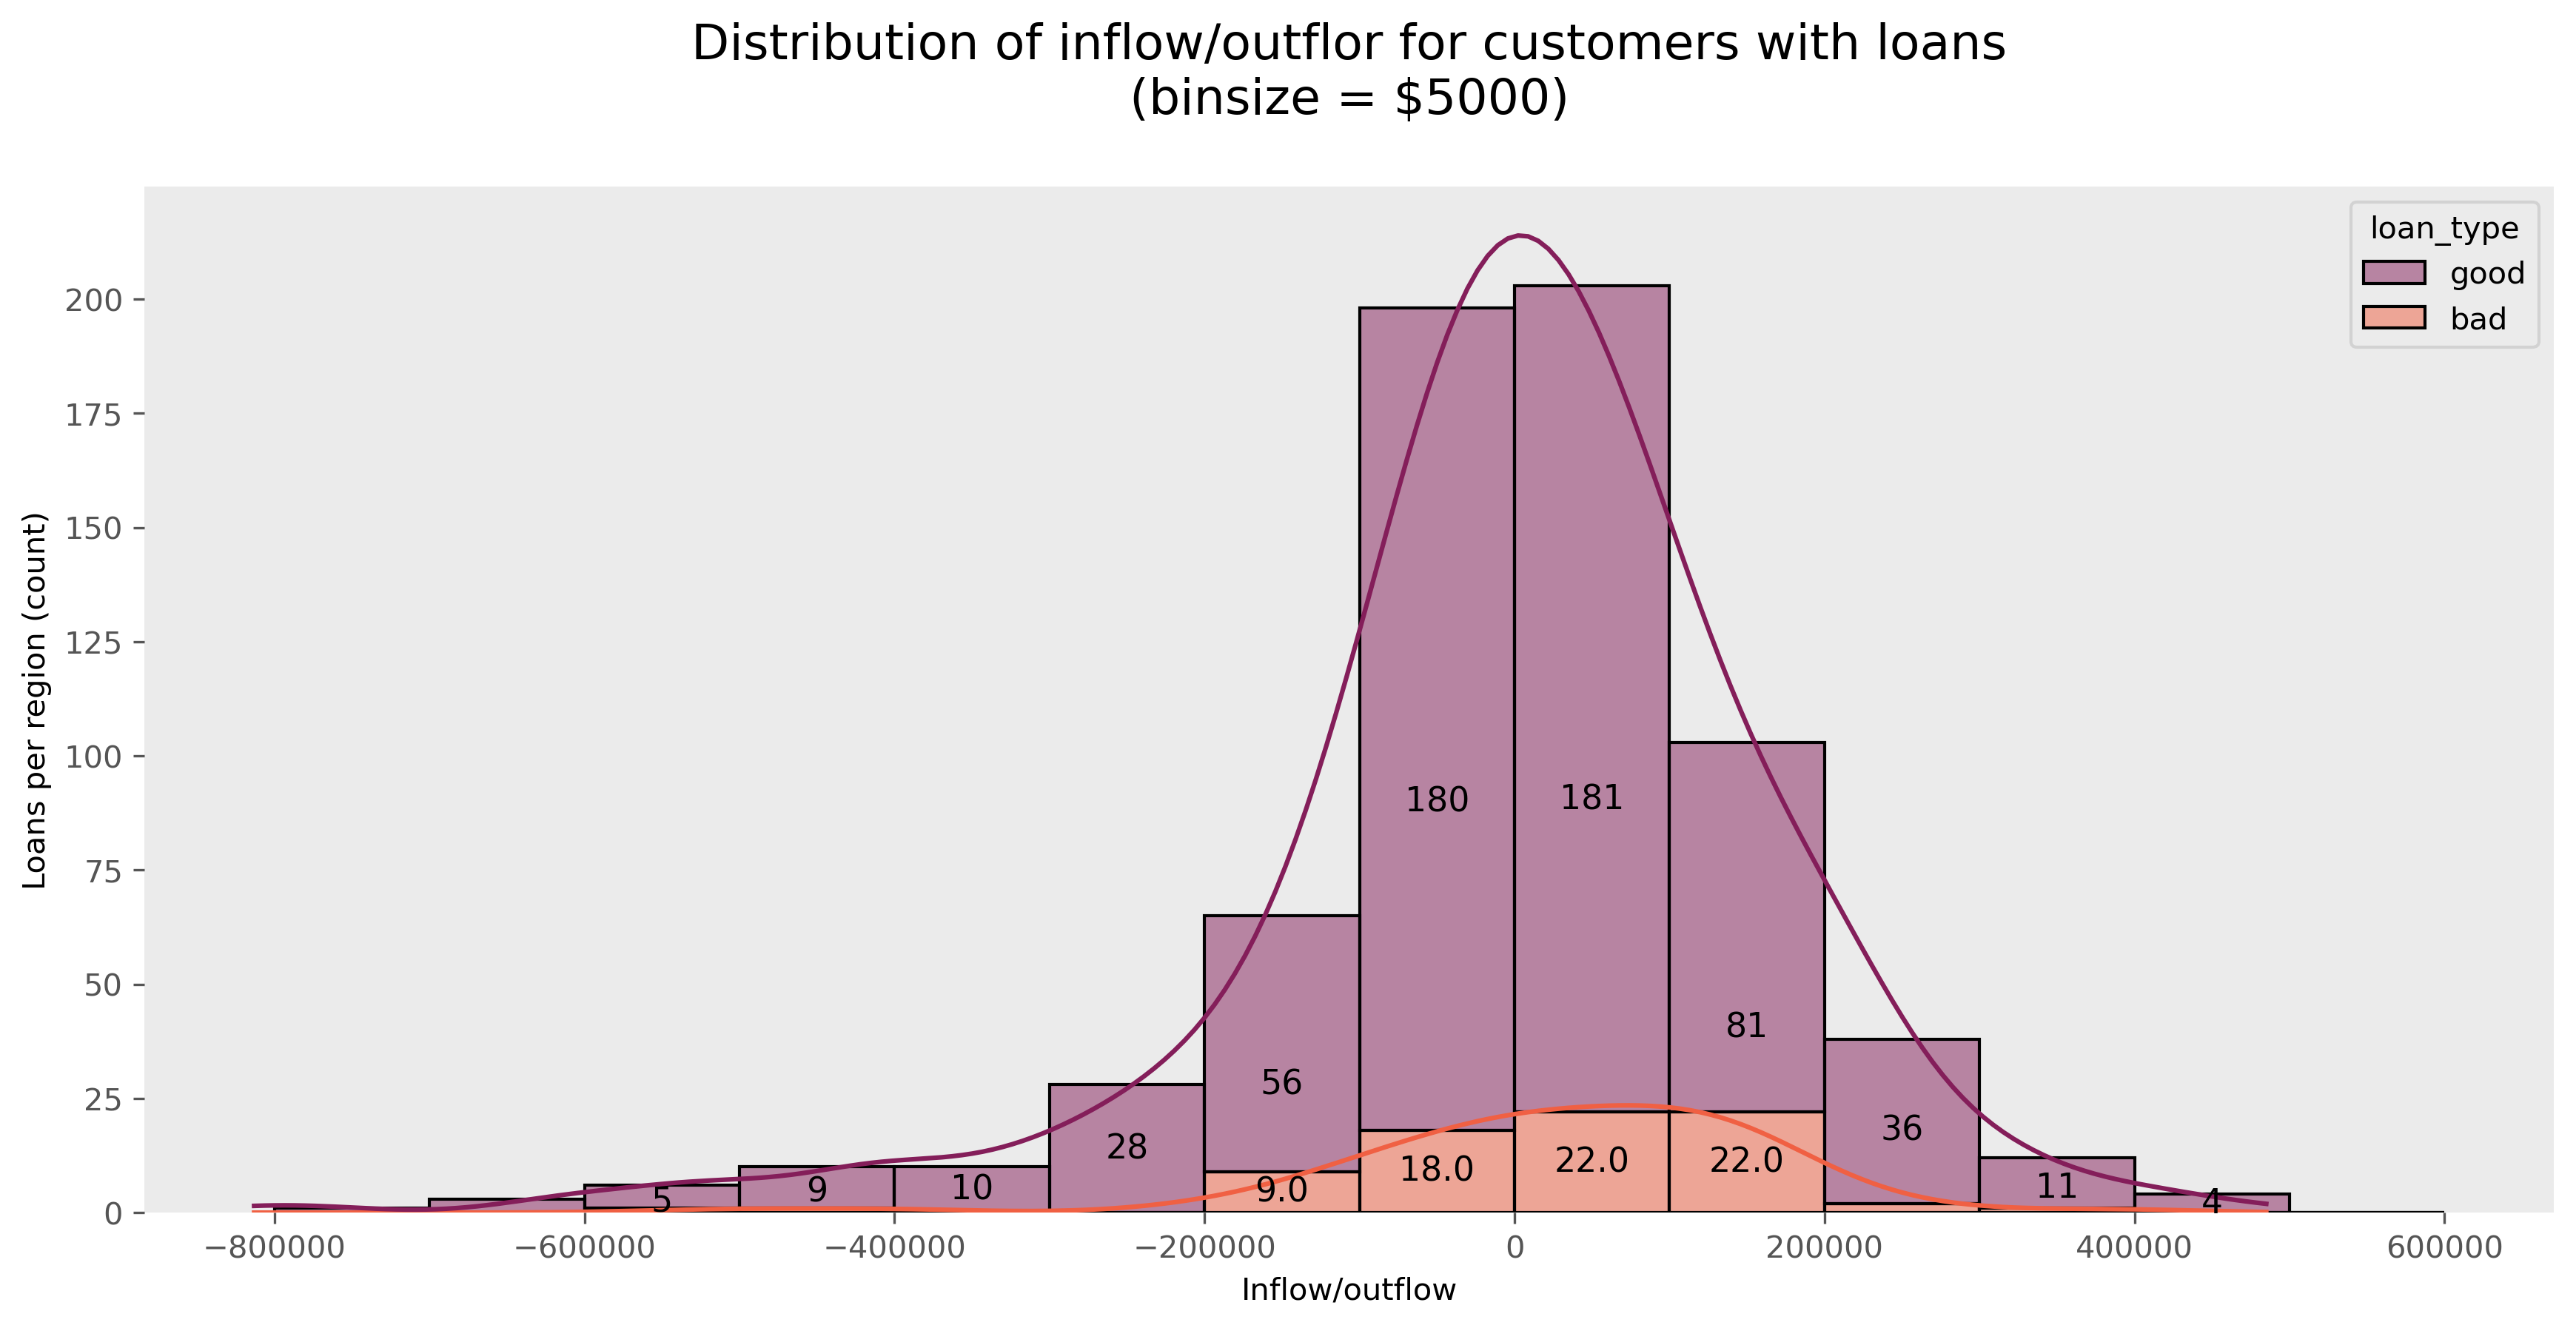

In [69]:
fig, ax1 = plt.subplots(1,1, figsize=(14,6), dpi=300)
sns.histplot(data=trans_loan, x='total_inflow/outflow', hue='loan_type', ax=ax1, multiple='stack',
             binwidth=100000 , binrange=(-800000,600000), kde=True, palette='rocket', element='bars') #poly

for bar in ax1.patches:
    if bar.get_height() < 4:
        continue
    ax1.annotate(format(bar.get_height(),),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()/2), ha='center', va='center',
                   size=11, xytext=(0, 0), color='black',
                   textcoords='offset points')
ax1.set_title('Distribution of inflow/outflor for customers with loans\n(binsize = $100000)\n', fontdict={'size':16})
ax1.set_ylabel('Loans per region (count)')
ax1.set_xlabel('Inflow/outflow')
ax1.grid(None)
plt.show()

In [74]:
try:
    cnx = mysql.connector.connect(**config)
    trans_loan = pd.read_sql_query(
        '''
        SELECT t.account_id, ROUND(AVG(t.balance),2) AS `average_balance`, l.loan_type
        FROM trans t, account a, loan l
        WHERE (t.account_id = a.account_id)
        AND (a.account_id = l.account_id)
        AND (l.loan_id IS NOT NULL)
        GROUP BY t.account_id
        ORDER BY l.loan_type DESC;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
trans_loan

,account_id,average_balance,loan_type
0,8713,32058.84,good
1,8784,50917.49,good
2,8931,61436.55,good
3,9034,38841.37,good
4,9104,57564.07,good
...,...,...,...
677,5066,43029.26,bad
678,5442,31849.28,bad
679,5927,16946.31,bad
680,7966,44745.91,bad


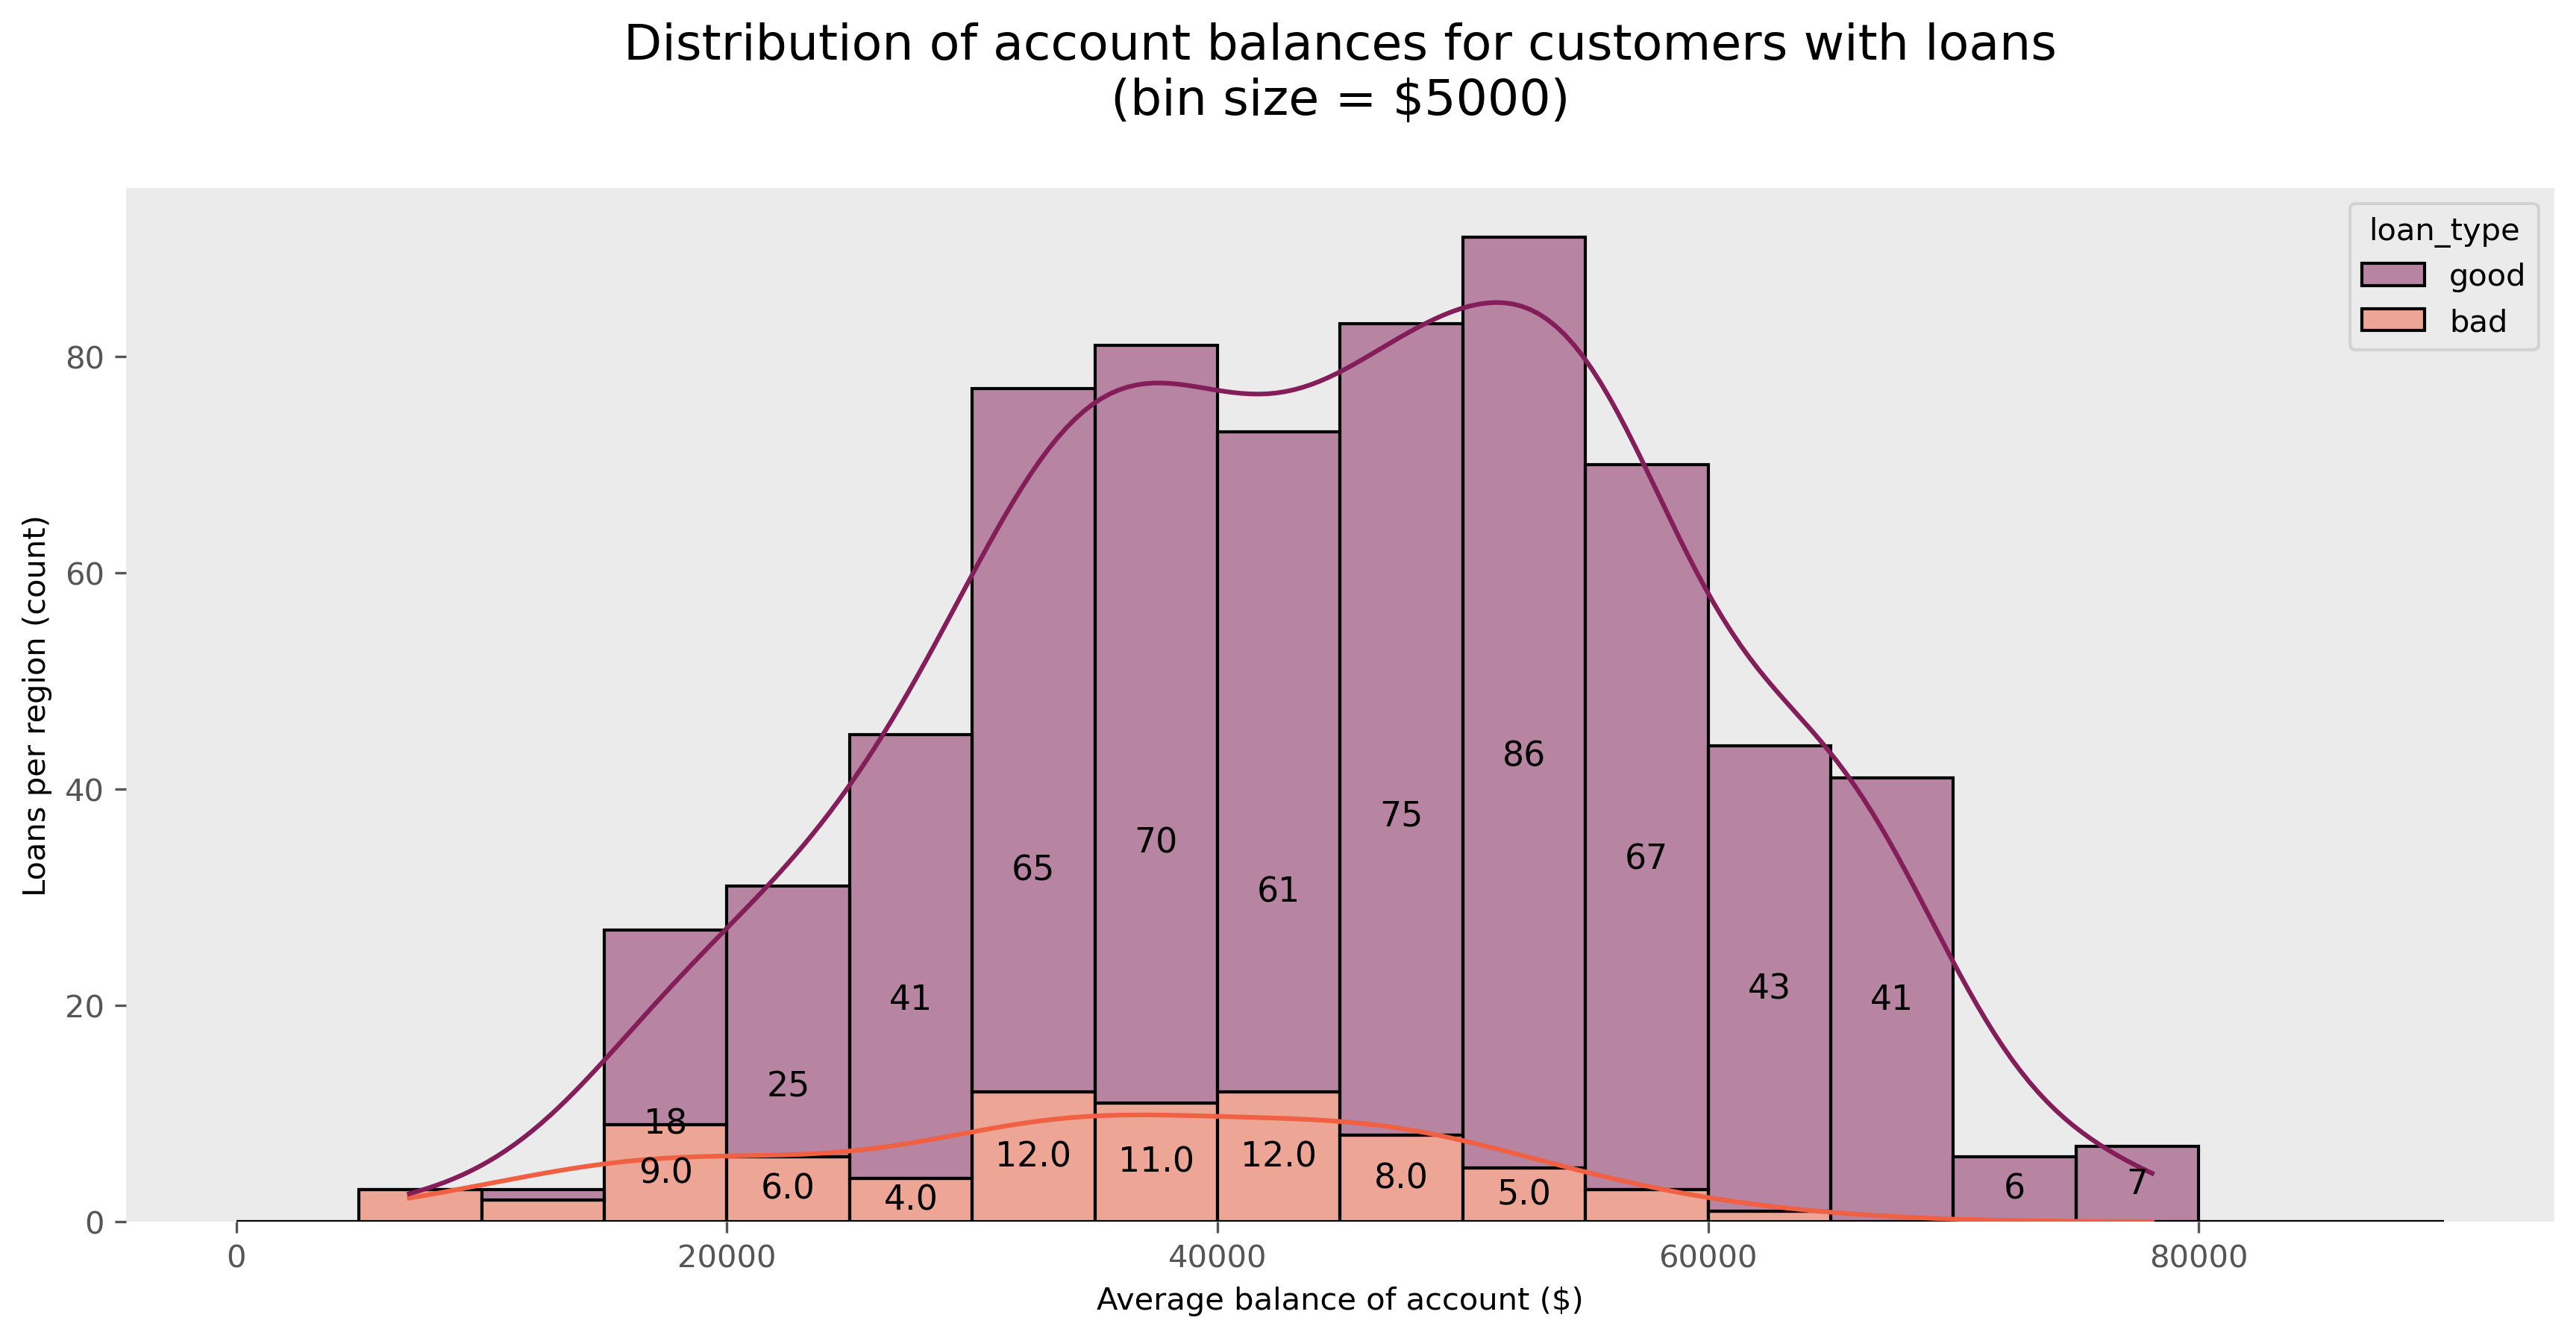

In [73]:
fig, ax1 = plt.subplots(1,1, figsize=(14,6), dpi=300)
sns.histplot(data=trans_loan, x='average_balance', hue='loan_type', ax=ax1, multiple='stack',
             binwidth=5000 , binrange=(0,90000), kde=True, palette='rocket', element='bars') #poly

for bar in ax1.patches:
    if bar.get_height() < 4:
        continue
    ax1.annotate(format(bar.get_height(),),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()/2), ha='center', va='center',
                   size=11, xytext=(0, 0), color='black',
                   textcoords='offset points')
ax1.set_title('Distribution of account balances for customers with loans\n(bin size = $5000)\n', fontdict={'size':16})
ax1.set_ylabel('Loans per region (count)')
ax1.set_xlabel('Average balance of account ($)')
ax1.grid(None)
plt.show()

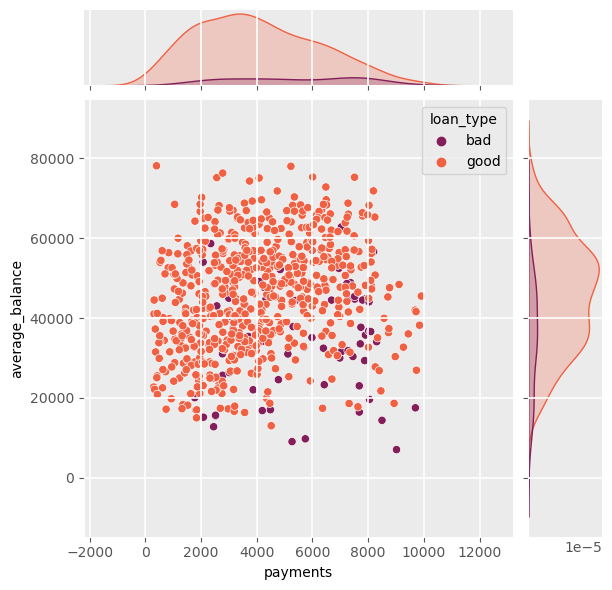

In [23]:
sns.jointplot(data=trans_loan, x='payments', y='average_balance', hue='loan_type', palette='rocket')

In [67]:
try:
    cnx = mysql.connector.connect(**config)
    loans = pd.read_sql_query(
        '''
        SELECT 
            amount, 
            CASE WHEN 
            loan_type
        FROM loan l
        ORDER BY status, amount;
        ''', con = cnx
    )
except Exception as e:
    print(e)
finally:
    cnx.close()
loans

,amount,loan_type
0,4980,good
1,7656,good
2,11400,good
3,11736,good
4,12540,good
...,...,...
677,460980,bad
678,465504,bad
679,473280,bad
680,482940,bad


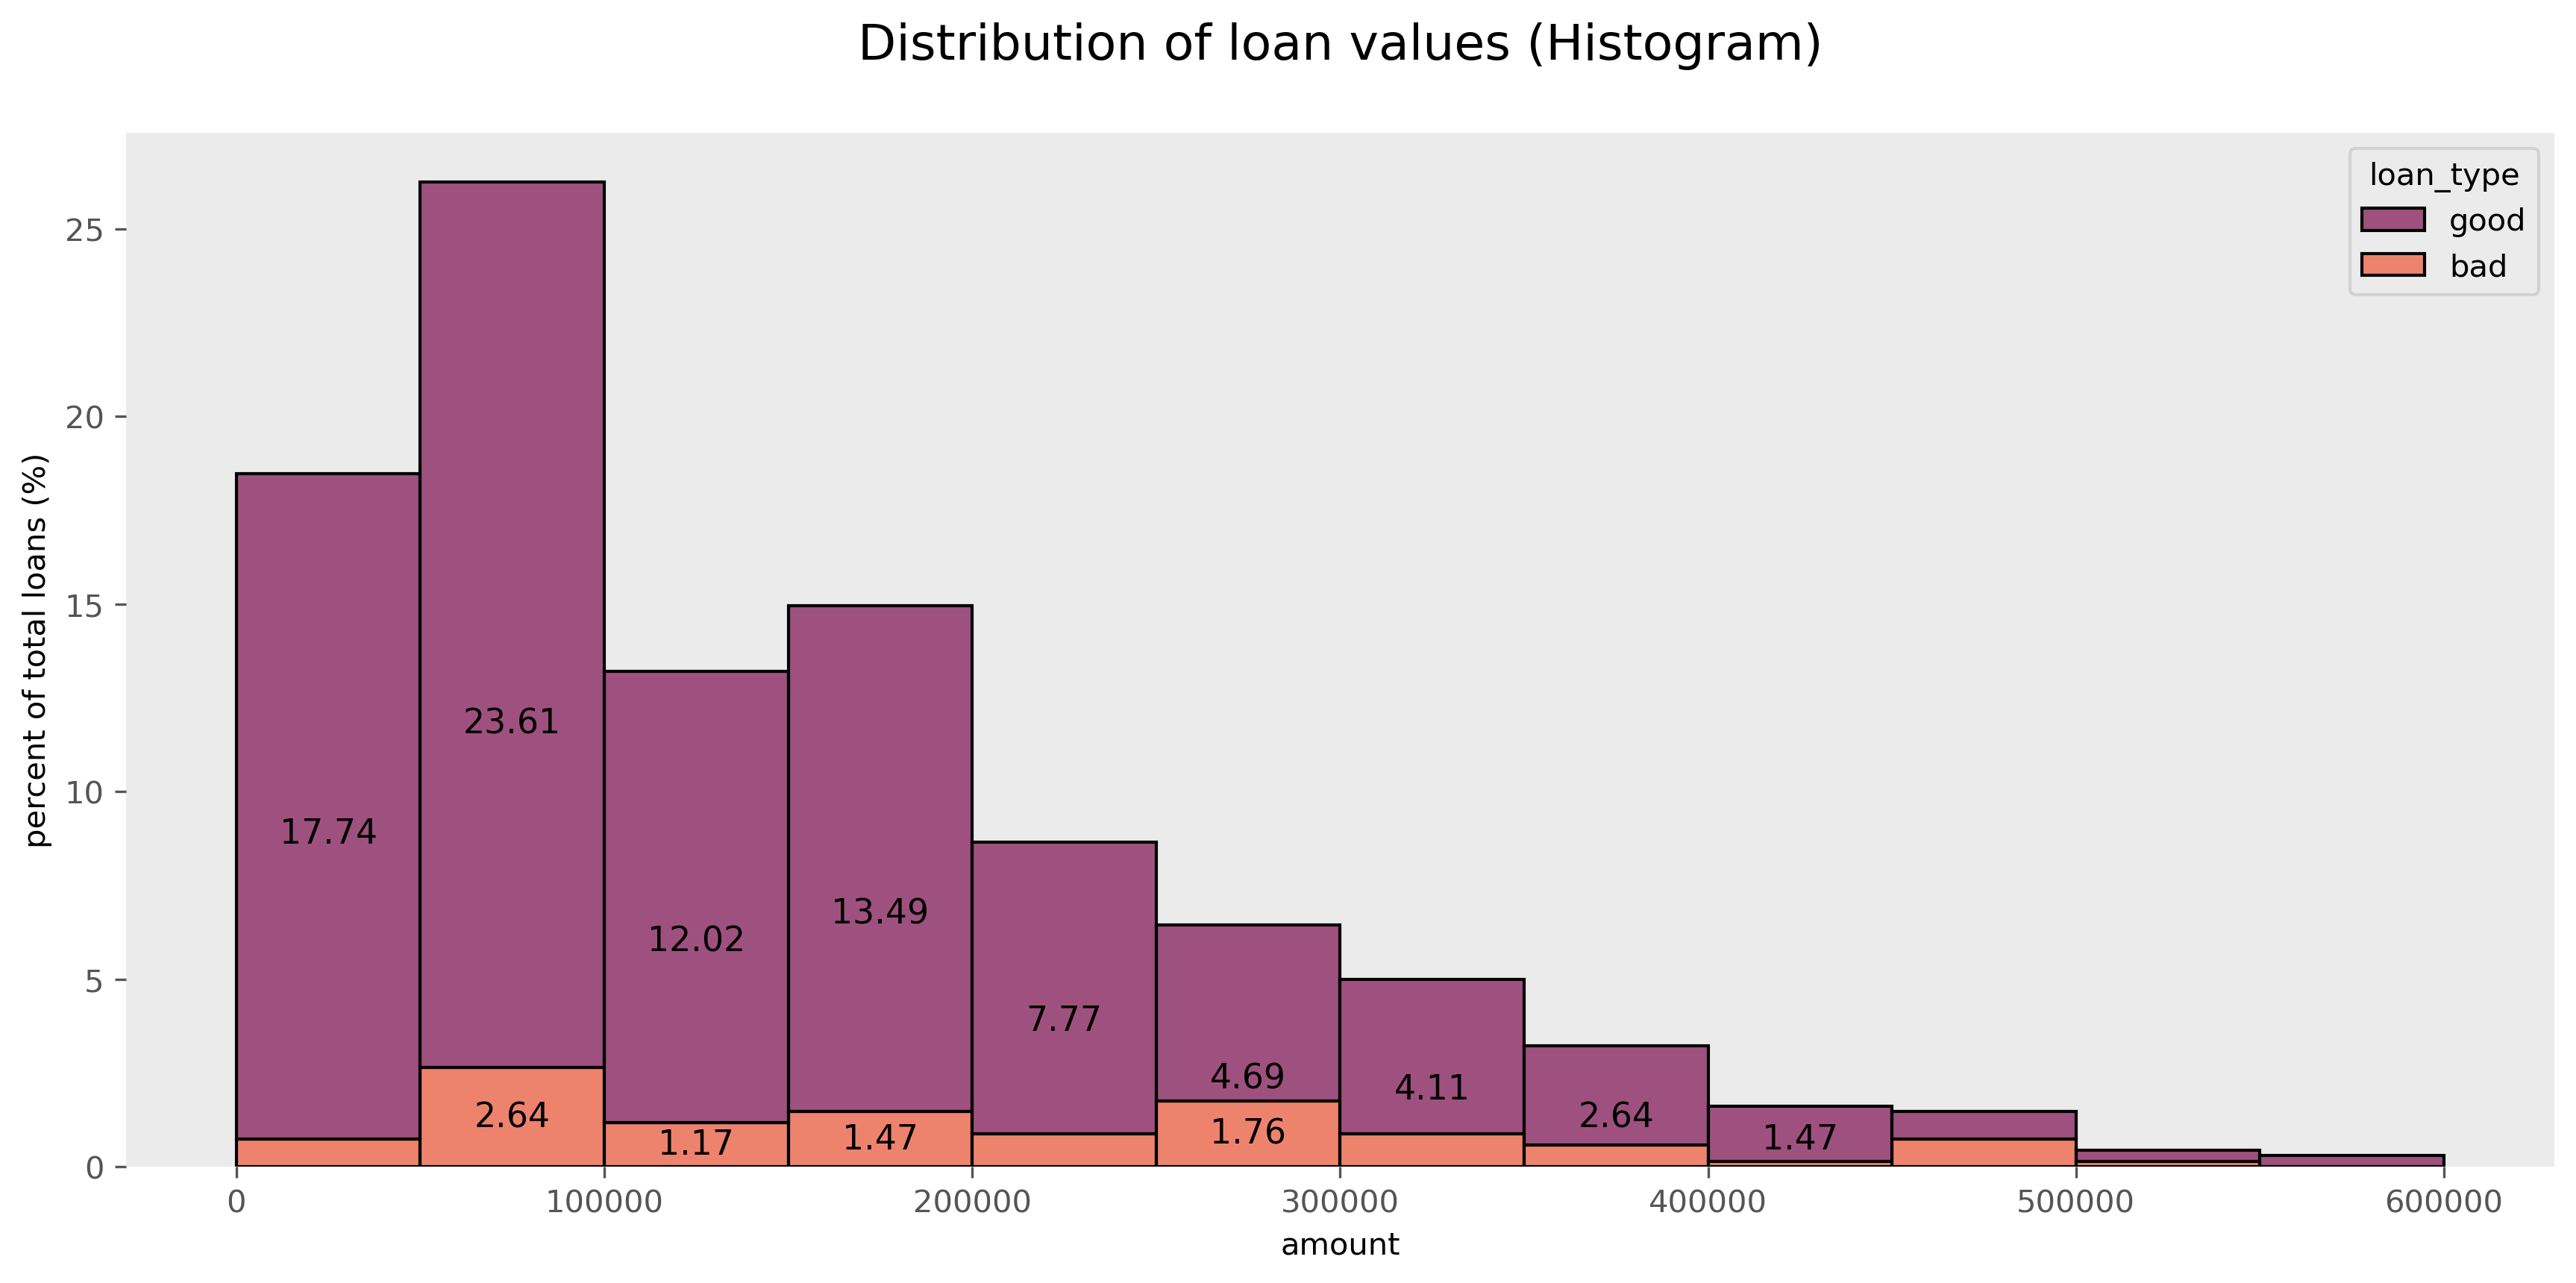

In [68]:
fig, ax1 = plt.subplots(1,1, figsize=(14,6), dpi=300)
sns.histplot(data=loans, x='amount', hue='loan_type', ax=ax1,
             stat='percent', binwidth=50000, binrange=(0,600000),
             multiple='stack', palette='rocket', element='bars') #poly

for bar in ax1.patches:
    if bar.get_height() < 1:
        continue
    ax1.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()/2), ha='center', va='center',
                   size=11, xytext=(0, 0), color='black',
                   textcoords='offset points')
ax1.set_title('Distribution of loan values (Histogram)\n', fontdict={'size':16})
ax1.set_ylabel('percent of total loans (%)')
ax1.grid(None)
plt.show()